In [1]:
import numpy as np
import pandas as pd

from glob import glob
import pydicom as dicom
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure

from tensorflow.keras.layers import Input
from preprocess import create_lung_mask, apply_lung_mask

2021-08-25 13:55:14.439490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [27]:
### Classify

In [2]:
data_path = "/home/samsmu/Data/Lung/CT"
dataset_path = data_path + "/DSB3/stage1"
output_path = data_path + "/DSB3_work"

### 1.Take middle part of lung series.  

In [ ]:
%%time
cut_percent_bottom = 0.3
cut_percent_top = 0.7

dir_list = glob(dataset_path +"/*")
print("Series overall: " , len(dir_list))
for d in dir_list:
    file_list = glob(d + "/*")
    print(len(file_list))

    file_list = glob(d + "/*")

    series_list = []
    #series_list.append()
    for fn in file_list:
        dcm = dicom.read_file(fn)
        series_list.append([int(dcm.InstanceNumber), dcm.pixel_array])
    series_list.sort()    
    series_imgs = [x[1] for x in series_list]
    start_series = int(cut_percent_bottom * len(series_imgs))
    end_series = int(cut_percent_top * len(series_imgs))
    series_imgs = series_imgs[start_series:end_series]
    
    series_fn = "middle_" + d.split("/")[-1] + ".npy"
    np.save(output_path + "/" + series_fn, series_imgs)


### 2. Create lung mask

In [ ]:
%%time
file_list = glob(output_path + "/middle*.npy")
for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        mask = create_lung_mask(img)
        imgs_to_process[i] = mask
    np.save(img_file.replace("middle","lungmask"), imgs_to_process)

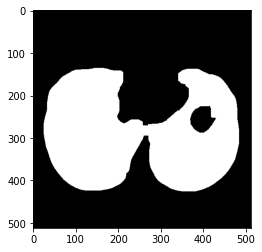

In [17]:
plt.imshow(mask, cmap = "gray")

### 3. Apply Lung mask to img

In [ ]:
%%time
file_list=glob(output_path+"/lungmask_*.npy")

for fname in file_list:
    print ("working on file ", fname)
    masks = np.load(fname)
    imgs_to_process = np.load(fname.replace("lungmask","middle"))
    out_images = []      #final set of images
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        mask = masks[i]        
        new_img, _ = apply_lung_mask(img, mask, None)
        if new_img is None:
            pass
        else:
            out_images.append(new_img)
            
    num_images = len(out_images)
    #
    #  Writing out images and masks as 1 channel arrays for input into network
    #
    final_images = np.ndarray([num_images, 512, 512, 1],dtype=np.float32)
    for i in range(num_images):
        final_images[i,...,0] = out_images[i]            
        np.save(fname.replace("lungmask", "final"), final_images)

#### 3.1 Test

Series shape: (60, 512, 512, 1)


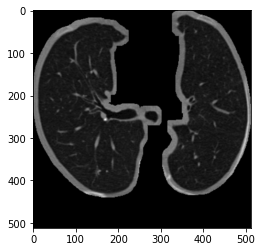

In [8]:
file_list = glob(output_path+"/final_*.npy")
out_images = np.load(file_list[0])
print("Series shape:", out_images.shape)
plt.imshow(out_images[5], cmap = "gray")

### End

In [4]:
xf = glob(output_path+"/final_*.npy")
len(xf)

20

In [5]:
xm = glob(output_path+"/middle_*.npy")
len(xm)

1594

In [6]:
xl = glob(output_path+"/lungmask_*.npy")
len(xl)

1594